In [83]:
import sys
import os

sys.path.append(os.path.abspath("./.."))

from utilities import dipole_utilities as ut
from utilities import analysis_tools as at

import numpy as np
import matplotlib.pyplot as plt


We load all the Pantheon+ dataset and the associated covariance matrix

In [2]:
# Load all columns as strings
plus0 = np.genfromtxt(
    "../data/pantheon_shoes.dat",
    usecols=(4, 10, 12, 13, 26, 27, 6, 2),  # Columns to extract
    skip_header=1,

)

# Convert columns to the correct types manually
plus0 = np.array(plus0)  # Ensure it's a NumPy array
zcmb = plus0[:, 0].astype(float)  # Convert column 0 to float
mu = plus0[:, 1].astype(float)    # Convert column 1 to float
ceph_dis = plus0[:, 2].astype(float)  # Column 2 to float
is_cal = plus0[:, 3].astype(float)    # Column 3 to float
ra = plus0[:, 4].astype(float)        # Column 4 to float
dec = plus0[:, 5].astype(float)       # Column 5 to float
zhel = plus0[:, 6].astype(float)      # Column 6 to float
zhd = plus0[:, 7].astype(float)       # Column 7 to float


In [44]:
covf = open("../data/Pantheon+SH0ES_STAT+SYS.cov").readlines()
covl = np.array(covf, dtype="float")
shape = covl[0]  # si prende la misura in questo modo, geniale
covmat = covl[1:].reshape((int(shape), int(shape)))


Let's correct the redshift for a monopole, a bulk and a quadrupole using the mean values reported in https://arxiv.org/pdf/2403.17741

In [75]:
#z_mono_bulk=ut.z_monopole_bulk(zhel, -95, 323, 199, -51.2, 74.1, 0.317, 369.82, 264.021, 48.253, ra, dec)

#z_mono_bulk_quadrupole=np.zeros(1701)

for i in range(1701):
    z_mono_bulk_quadrupole[i]=ut.z_monopole_bulk_quadrupole(zhel[i], -90, 322,200,-53.1, 74.1, 0.317, ut.symmetric_traceless_matrix(-13, 51, 33, 37, 47), 369,167.942, -6.944,ra[i],dec[i])


We then compute the corresponding distance moduli

In [25]:
monopole=np.zeros(1701)
mono_bulk=np.zeros(1701)
mono_bulk_quadrupole=np.zeros(1701)

for i in range(1701):
    monopole[i]=ut.monopole(zhel[i], 74.1, 0.317)
    mono_bulk[i]=ut.monopole(z_mono_bulk[i], 74.1, 0.317)
    mono_bulk_quadrupole[i]=ut.monopole(z_mono_bulk_quadrupole[i], 74.1, 0.317)

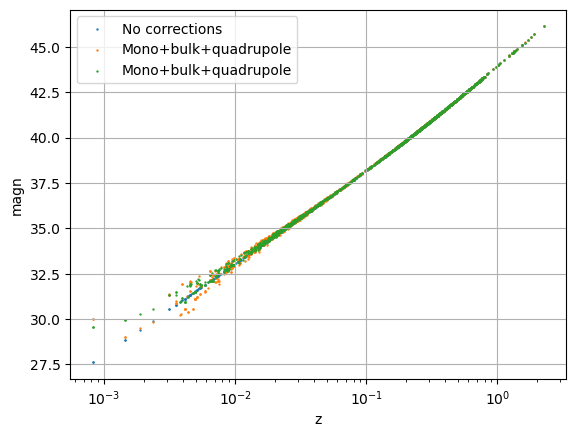

In [33]:
plt.scatter(zhel, monopole, s=0.5, label='No corrections')
plt.scatter(zhel, mono_bulk, s=0.5,label='Mono+bulk+quadrupole')
plt.scatter(zhel, mono_bulk_quadrupole, s=0.5,label='Mono+bulk+quadrupole')

plt.legend()
plt.xscale('log')
plt.xlabel('z')
plt.ylabel('magn')
plt.grid()

We plot and visualize the residuals

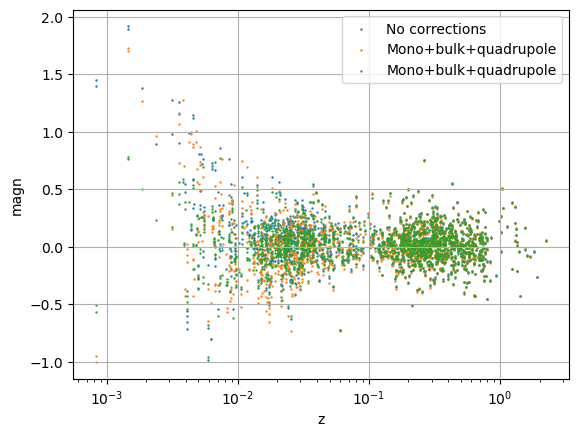

In [127]:
plt.scatter(zhel, mu-monopole, s=0.5, label='No corrections')
plt.scatter(zhel, mu-mono_bulk, s=0.5,label='Mono+bulk+quadrupole')
plt.scatter(zhel, mu-mono_bulk_quadrupole, s=0.5,label='Mono+bulk+quadrupole')

plt.legend()
plt.xscale('log')
plt.xlabel('z')
plt.ylabel('magn')
plt.grid()

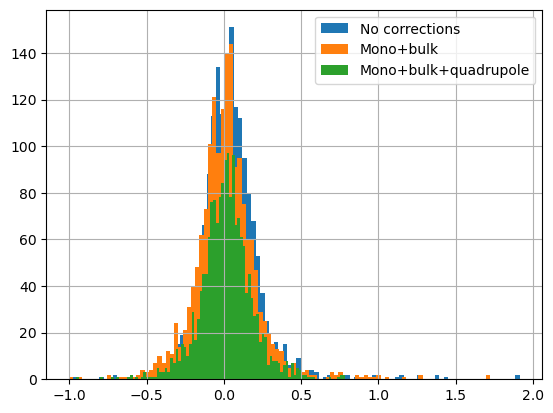

In [30]:
plt.hist(mu-monopole, bins=100, label='No corrections')
plt.hist(mu-mono_bulk, bins=100, label='Mono+bulk')

plt.hist(mu-mono_bulk_quadrupole, bins=100, label='Mono+bulk+quadrupole')


plt.grid()
plt.legend()

In [38]:
import emcee
from scipy.stats import multivariate_normal


# MCMC sampling

We reduce the dataset considering only supernovae wiyh 1e-4 < z <1e-1 but keeping all the cepheids

In [ ]:
zcmb = plus0[:, 0].astype(float)  # Convert column 0 to float
mu = plus0[:, 1].astype(float)    # Convert column 1 to float
ceph_dis = plus0[:, 2].astype(float)  # Column 2 to float
is_cal = plus0[:, 3].astype(float)    # Column 3 to float
ra = plus0[:, 4].astype(float)        # Column 4 to float
dec = plus0[:, 5].astype(float)       # Column 5 to float
zhel = plus0[:, 6].astype(float)      # Column 6 to float
zhd =

In [134]:
zhel_prefilter = plus0[:, 6]
is_cal_prefilter = plus0[:, 3]



filtered_data_file = ut.filter_z_cepheid(plus0, covmat, zhel_prefilter, is_cal_prefilter, 1e-4, 1e-1)[0]
covmat_filtered = ut.filter_z_cepheid(
    plus0, covmat, zhel_prefilter, is_cal_prefilter, 1e-4, 1e-1
)[1]


# therefore we can use just one of the two set for position and redshift but not for the rest
zcmb_filtered = filtered_data_file[:, 0]
mu_filtered = filtered_data_file[:, 1]
ceph_dis_filtered = filtered_data_file[:, 2]
is_cal_filtered = filtered_data_file[:, 3]
ra_filtered = filtered_data_file[:, 4]
dec_filtered = filtered_data_file[:, 5]
zhel_filtered = filtered_data_file[:, 6]


In [135]:
def log_prior(theta, priors):
    """
    Optimized log-prior for the parameters (uniform and Gaussian), using NumPy.
    
    Parameters:
    - theta: numpy array of free parameters.
    - priors: list of two elements (mu and halfwidth).
        - mu: numpy array of means for each parameter.
        - halfwidth: numpy array of halfwidths for each parameter.
        
    Returns:
    - log_prior_value: float representing the log-prior. 
                       Returns -np.inf if any parameter is outside the prior range.
    """
    # Extract mu and halfwidth
    mu, halfwidth = priors

    # Precompute the lower and upper bounds
    lower_bound = mu - halfwidth
    upper_bound = mu + halfwidth

    # Check if any parameter is outside the uniform bounds
    outside_uniform = (theta > upper_bound) | (theta < lower_bound)
    
    # If any parameter is out of bounds, return -inf
    if np.any(outside_uniform):
        return -np.inf

    return 0


def log_likelihood(parameters: list[float]):
    (
        M,
        H0,
        Omat,
    ) = parameters


    res=ut.exp_obs_monopole_with_M(
        M, H0, Omat, mu, zhel_filtered, horstmann=False, is_cal=is_cal_filtered, ceph=ceph_dis_filtered, no_cepheid=None
    )

    l=len(zhel_filtered)

    return multivariate_normal.logpdf(np.zeros(l), mean=res, 
                                                    cov=np.array(covmat_filtered))



def log_probability(parameters: list[float], priors):
    """
    log-probability that governs the rate of acceptance for given proposed parameter.
    """
    lp = log_prior(parameters, priors)
    if not np.isfinite(lp):
        return -np.inf

    ll = log_likelihood(parameters)
    if not np.isfinite(ll):
        return -np.inf

    return lp+ll 



def run_MCMC(
    nwalkers,
    number_of_steps,
    parameters_values,
    prior_width,
    outpath=None,
    contd=None,
):
    """
    a wrapper file
    """

    # inversed_covariance=inversed_covariance_data

   # with MPIPool() as pool:
   #     if not pool.is_master():
   #         pool.wait()
   #         sys.exit(0)

    if outpath is None:
        outpath = "./results.h5"
    # load data

    # priors
    reference_values = np.array(parameters_values, dtype=float)
    widths = np.array(prior_width)
    priors = [reference_values, widths]

    # initial guess array for each walker:
    x0 = np.random.uniform(
        reference_values - widths,
        reference_values + widths,
        size=(nwalkers, len(reference_values)),
    )
    nwalkers, ndim = x0.shape

    # save file
    backend = emcee.backends.HDFBackend(outpath)
    if contd:  # it is true if you want to continue the run
        print(f"initial size: {backend.iteration}", flush=True)
    else:
        backend.reset(nwalkers, ndim)

        # initialize sampler, run MCMC
    sampler = emcee.EnsembleSampler(
        nwalkers,
        ndim,
        log_probability,
        args=[priors],
        backend=backend,
    #       pool=pool,
    )

    if contd:
        sampler.run_mcmc(
            None, number_of_steps, progress=True, skip_initial_state_check=True
        )
        print(f"final size: {backend.iteration}", flush=True)
    else:
        sampler.run_mcmc(
            x0, number_of_steps, progress=True, skip_initial_state_check=True
        )



In [138]:
PARAMETERS_VALUES = [
    0,
    70,
    0.3,
]  # before it was 0.334
PRIOR_WIDTH = [
    0.5,
    30,
    0.2,
]

In [144]:
run_MCMC(
    1000,
    6,
    PARAMETERS_VALUES,
    PRIOR_WIDTH,
    "../chains/test.h5",
    True  #True to continue the run
    )

initial size: 6


100%|██████████| 6/6 [42:30<00:00, 425.07s/it]

final size: 12


In [145]:
reader = emcee.backends.HDFBackend("../chains/test.h5")
tau = reader.get_autocorr_time()
print(tau)
burnin = 5
loaded_chain=reader.get_chain(flat=True, discard=burnin)

[nan nan nan]


/opt/anaconda3/lib/python3.11/site-packages/emcee/autocorr.py:38: RuntimeWarning: invalid value encountered in divide
  acf /= acf[0]


Removed no burn in


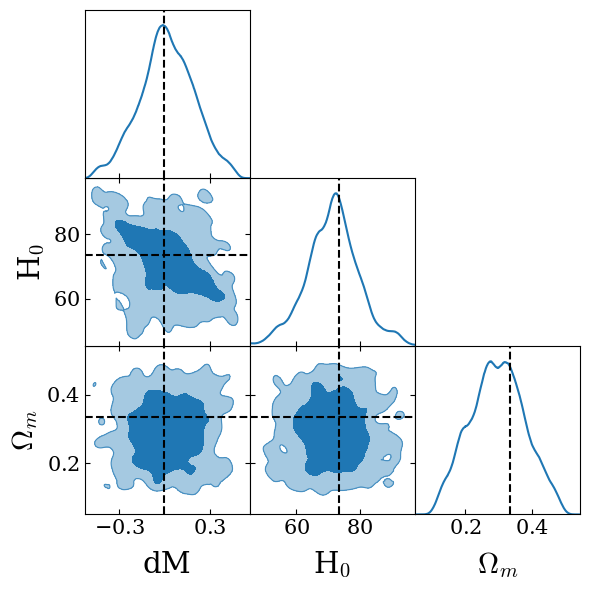

In [146]:
at.plot_getdist([loaded_chain], names_parameter=['dM',r'H$_0$',r'$\Omega_m$'],truth_values=[0,  73.6,0.334],smoothing_1D=0.2,smoothing_2D=0.2,)

# Plotting results

We upload and plot two chain for the full analysis (monopole+bulk+quadrupole)

In [148]:
#load the chain considering all the supernovae
flatchain_monopole_bulk_quadrupole_no_filter=at.flatchain('../chains/monopole_bulk_quadrupole_no_filter.h5')

flatchain_monopole_bulk_quadrupole_no_filter[:,3]=np.rad2deg(np.arccos(flatchain_monopole_bulk_quadrupole_no_filter[:,3]))-90 


# Computing the symmetric traceless matrix using custom function ut.symmetric_traceless_matrix
matrix1 = ut.symmetric_traceless_matrix(
    flatchain_monopole_bulk_quadrupole_no_filter[:, 4],
    flatchain_monopole_bulk_quadrupole_no_filter[:, 5],
    flatchain_monopole_bulk_quadrupole_no_filter[:, 6],
    flatchain_monopole_bulk_quadrupole_no_filter[:, 7],
    flatchain_monopole_bulk_quadrupole_no_filter[:, 8],
)

# Reshaping the array to (277568, 3, 3) for efficient vectorized operations
matrix1_reshaped = matrix1.transpose(2, 0, 1)

# Vectorized eigenvalue calculation for each 3x3 matrix in matrix1_reshaped
eigenvalues_and_vectors_list = [
    at.find_eigenvalues_eigenvectors(mat) for mat in matrix1_reshaped
]

# Unpack eigenvalues and eigenvectors separately
eigenvalues_list = [eig_and_vec[0] for eig_and_vec in eigenvalues_and_vectors_list]

eigenvectors_list = [eig_and_vec[1] for eig_and_vec in eigenvalues_and_vectors_list]


# Combine selected columns from flatchain_quadrupole and eigenvalues_list
flatchain_monopole_bulk_quadrupole_with_eigenvalues_no_filter = np.hstack(
    (flatchain_monopole_bulk_quadrupole_no_filter[:, [0, 1, 2,3, 9, 10, 11]], eigenvalues_list)
)

